In [13]:
import pandas as pd
import numpy as np
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


PyTorch Version: 2.5.1
CUDA Available: True
GPU Name: NVIDIA GeForce RTX 4090 Laptop GPU


In [14]:
def hyperbolic_discounting_loss(preds, targets, confs, beta=0.5):
    """
    Calculate loss with hyperbolic discounting and confidence weighting.
    Args:
        preds: Predicted prices (batch_size, 4)
        targets: True prices (batch_size, 4)
        confs: Predicted confidence values (batch_size, 4)
        beta: Hyperbolic discount factor (smaller = more discounting for distant horizons)
    """
    time_horizons = torch.tensor([1, 5, 21, 252], device=preds.device)  # Trading days
    discount_weights = 1 / (1 + beta * time_horizons)
    mse_loss = (preds - targets).pow(2)
    weighted_loss = discount_weights * mse_loss / (confs + 1e-6)  # Confidence adjustment
    confidence_penalty = torch.log(confs + 1e-6).mean()  # Encourage confident predictions
    return weighted_loss.mean() + 0.01 * confidence_penalty  # Regularize confidence


In [15]:
# read data
input_data = pd.read_csv('../data/training_raw.csv')

# Define horizons for target predictions (trading days)
horizons = {"1_day": 1, "1_week": 5, "1_month": 21, "1_year": 252}

# Step 1: Create Target Columns
def create_targets(df, target_column, horizons):
    """
    Generate shifted target columns for specified horizons.
    """
    for horizon, shift in horizons.items():
        df[f"Target_{horizon}"] = df[target_column].shift(-shift)
    return df

# Step 2: Normalize Features
def normalize_features(df, exclude_columns):
    """
    Normalize input features using Min-Max scaling, excluding specified columns.
    """
    scaler = MinMaxScaler()
    input_features = df.drop(columns=exclude_columns)
    scaled_features = scaler.fit_transform(input_features)
    
    # Reconstruct normalized DataFrame
    normalized_df = pd.DataFrame(scaled_features, columns=input_features.columns, index=input_features.index)
    for column in exclude_columns:
        normalized_df[column] = df[column]  # Add back excluded columns (e.g., targets)
    
    return normalized_df, scaler

# Step 3: Create Sequences for Transformer Input
def create_sequences(data, target_columns, seq_length):
    """
    Create sequences for transformer input with specified sequence length.
    """
    X, y = [], []
    data_values = data.drop(columns=target_columns).values
    target_values = data[target_columns].values

    for i in range(len(data) - seq_length):
        X.append(data_values[i:i + seq_length])
        y.append(target_values[i + seq_length])
    
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Step 4: Custom Dataset for PyTorch
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Full Data Preparation Pipeline
def prepare_data_pipeline(df, target_column, sequence_length=30):
    """
    Prepare data for transformer input: normalize, create targets, and generate sequences.
    """
    # Create targets
    df = create_targets(df, target_column, horizons)

    # Normalize features
    exclude_columns = [f"Target_{horizon}" for horizon in horizons.keys()]
    df, scaler = normalize_features(df, exclude_columns)

    # Drop NaN values
    df.dropna(inplace=True)

    # Split data into training, validation, and test sets
    train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)
    train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=False)

    # Create sequences
    target_columns = exclude_columns
    train_X, train_y = create_sequences(train_df, target_columns, sequence_length)
    val_X, val_y = create_sequences(val_df, target_columns, sequence_length)
    test_X, test_y = create_sequences(test_df, target_columns, sequence_length)

    # Create DataLoaders
    batch_size = 32
    train_loader = DataLoader(StockDataset(train_X, train_y), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(StockDataset(val_X, val_y), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(StockDataset(test_X, test_y), batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, scaler

# Example Usage
# Assuming combined_df is the enriched DataFrame
target_column = "COST_Close"
sequence_length = 256 # 21 = 1 month, 252 = 1 year

# Prepare the data
input_data = input_data.drop(columns = ['Date'])  # Reset index to avoid misalignment
train_loader, val_loader, test_loader, scaler = prepare_data_pipeline(input_data, target_column, sequence_length)

# Display the shapes of the datasets
print(f"Train Loader: {len(train_loader.dataset)} samples")     
print(f"Validation Loader: {len(val_loader.dataset)} samples")
print(f"Test Loader: {len(test_loader.dataset)} samples")


Train Loader: 2059 samples
Validation Loader: 323 samples
Test Loader: 468 samples


In [16]:
import sys
from pathlib import Path

# Add the src directory to sys.path if not already present
src_path = Path.cwd().parent / "src"
if str(src_path) not in sys.path:
	sys.path.append(str(src_path))

from model_def import StockPriceTransformer

In [21]:
# Model parameters
embed_dim = 128
num_heads = 8
num_layers = 4
epochs = 500

# get input dimensions from first batch
batch_X, _ = next(iter(train_loader))
input_dim = batch_X.shape[-1]
print(f"Input dimension: {input_dim}")

model = StockPriceTransformer(
    input_dim=input_dim,
    embed_dim=embed_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    output_dim=len(horizons),  # 4 targets for 1 day, 1 week, 1 month, and 1 year
    dropout=0.2
).to(device)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
print(model)


Input dimension: 247
StockPriceTransformer(
  (embedding): Linear(in_features=247, out_features=128, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (fc_price): Linear(in_features=128, out_features=4, bias=True)
  (fc_conf): Linear(in_features=128, out_features=4, bias=True)
)


In [ ]:
train_loss_arr, val_loss_arr = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0

    # Training batch loop
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        # Forward pass
        price_preds, conf_preds = model(X)
        loss = hyperbolic_discounting_loss(price_preds, y, conf_preds)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss_arr.append(train_loss / len(train_loader))

    # Validation loop
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)

            # Forward pass for validation
            price_preds, conf_preds = model(X)
            loss = hyperbolic_discounting_loss(price_preds, y, conf_preds)
            val_loss += loss.item()

    val_loss_arr.append(val_loss / len(val_loader))
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}")

# Save the model
torch.save(model.state_dict(), "stock_price_transformer.pth")


Epoch 1/500, Train Loss: 1573.1695, Val Loss: 7192.4142
Epoch 2/500, Train Loss: 921.5219, Val Loss: 6317.3402
Epoch 3/500, Train Loss: 817.1002, Val Loss: 5759.8710
Epoch 4/500, Train Loss: 746.5881, Val Loss: 5308.3207
Epoch 5/500, Train Loss: 683.1670, Val Loss: 4928.4293
Epoch 6/500, Train Loss: 631.8609, Val Loss: 4611.2601
Epoch 7/500, Train Loss: 587.0503, Val Loss: 4330.3157
Epoch 8/500, Train Loss: 551.0733, Val Loss: 4087.5035
Epoch 9/500, Train Loss: 514.9910, Val Loss: 3870.8593
Epoch 10/500, Train Loss: 483.4275, Val Loss: 3678.7066
Epoch 11/500, Train Loss: 458.7026, Val Loss: 3505.7378
Epoch 12/500, Train Loss: 434.9062, Val Loss: 3347.4949
Epoch 13/500, Train Loss: 410.6881, Val Loss: 3203.1544
Epoch 14/500, Train Loss: 392.3934, Val Loss: 3071.8395
Epoch 15/500, Train Loss: 373.3224, Val Loss: 2949.9868
Epoch 16/500, Train Loss: 355.4226, Val Loss: 2837.9386
Epoch 17/500, Train Loss: 339.9550, Val Loss: 2733.5000
Epoch 18/500, Train Loss: 325.3766, Val Loss: 2636.3189


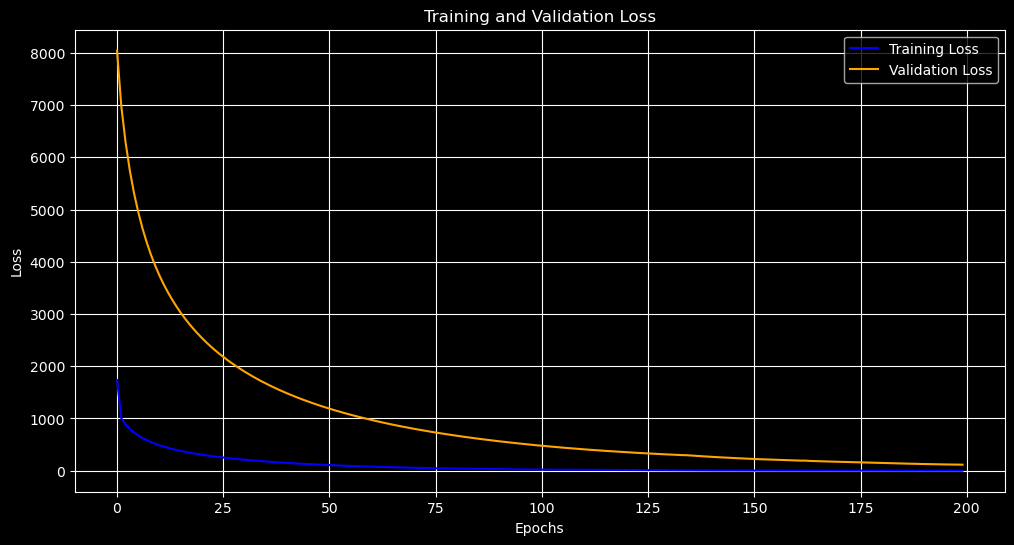

In [ ]:
# Plot tran val losses
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.figure(figsize=(12, 6))
plt.plot(train_loss_arr, label='Training Loss', color='blue')
plt.plot(val_loss_arr, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')  
plt.legend()
plt.grid(True)
plt.show()

In [20]:
### Test set ###
all_price_preds = []
all_conf_preds = []

with torch.no_grad():
    for X, _ in test_loader:  # _ if targets included, ignore during inference
        X = X.to(device)
        price_preds, conf_preds = model(X)
        all_price_preds.append(price_preds.cpu())
        all_conf_preds.append(conf_preds.cpu())

# Concatenate all batches
all_price_preds = torch.cat(all_price_preds, dim=0).numpy()
all_conf_preds = torch.cat(all_conf_preds, dim=0).numpy()

print("Test Price Predictions shape:", all_price_preds.shape)
print("Test Confidence Predictions shape:", all_conf_preds.shape)

print(all_price_preds[:5])  # Display first 5 predictions
print(all_conf_preds[:5])  # Display first 5 confidence predictions
print('max conf:', np.max(all_conf_preds), 'max price:', np.max(all_price_preds))

Test Price Predictions shape: (468, 4)
Test Confidence Predictions shape: (468, 4)
[[182.14885 181.30913 180.55212 194.36635]
 [182.14868 181.30893 180.55196 194.36598]
 [182.14389 181.30338 180.5455  194.35664]
 [182.14742 181.3075  180.55032 194.36354]
 [182.14902 181.3093  180.55243 194.3666 ]]
[[64.050674 57.254547 51.84976  47.16583 ]
 [64.05046  57.25435  51.84965  47.16572 ]
 [64.04375  57.247955 51.843784 47.15949 ]
 [64.04866  57.252644 51.84819  47.164135]
 [64.05086  57.25471  51.850166 47.166245]]
max conf: 64.25621 max price: 194.64653
